Oct 12th 2025

## Objective:
Use previously pre-processed data and fit a suite of classification models in a modular pipeline. The models chosen are logistic regression, Decision Tree and Random Forest. Optimise all 3 models for hyperparamters and evaluate performance using ROC-AUC curve and accuracy. Finally write the optimized model objects in artifacts.

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.decomposition import PCA
import xgboost as xgb

## Loading pre-processed data

In [2]:
path_to_dataset = r'C:\\\\Users\\\\patil\\\\Documents\\\\GitHub\\\\ml_projects\\\\heart_disease_prediction\\\\data\\\\processed'
filename = 'processed_data.csv'
full_file_path = os.path.join(path_to_dataset, filename)
df = pd.read_csv(full_file_path, index_col=False)

In [3]:
df

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,63,1,145.0,233.0,1,150.0,0,2.3,0.0,0,...,1,1,0,0,1,0,0,1,0,0
1,67,1,160.0,286.0,0,108.0,1,1.5,3.0,1,...,0,1,0,0,0,1,0,0,1,0
2,67,1,120.0,229.0,0,129.0,1,2.6,2.0,1,...,0,1,0,0,0,1,0,0,0,1
3,37,1,130.0,250.0,0,187.0,0,3.5,0.0,0,...,0,0,1,0,1,0,0,0,1,0
4,41,0,130.0,204.0,0,172.0,0,1.4,0.0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0,127.0,333.0,1,154.0,0,0.0,NaN,1,...,0,0,0,1,0,1,0,0,1,0
916,62,1,NaN,139.0,0,NaN,1,NaN,NaN,0,...,1,0,0,1,0,1,0,0,0,1
917,55,1,122.0,223.0,1,100.0,0,0.0,NaN,1,...,0,0,0,1,0,1,0,1,0,0
918,58,1,NaN,385.0,1,NaN,0,NaN,NaN,0,...,0,1,0,0,0,1,0,0,0,1


In [4]:
x = df.drop('num', axis = 1)
x = x.to_numpy()
x.shape

(920, 22)

In [5]:
y = df['num'].to_numpy()
y.shape

(920,)

##  Logistic Regression

### Fit the model

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [7]:
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)
model = LogisticRegression(random_state=42)
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)

In [8]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', model)])

In [9]:
scores = cross_validate(estimator=pipeline, X=x_train, y=y_train, cv=kf, scoring='accuracy', return_train_score = True)

In [10]:
scores['train_score'].mean(), scores['test_score'].mean()

(0.8154447622532729, 0.8028296814087915)

### ROC curve for Logistic Regression
For ROC, we need to do train test split (cross val has 4 splits and ROC curve needs only 1 training and testing set

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [12]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', model)])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))])

In [13]:
y_pred = pipeline.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8130434782608695

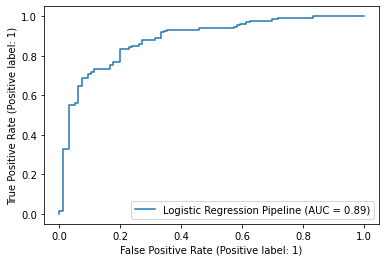

In [14]:
# plt.figure(figsize= (15,7.5))

roc_display = RocCurveDisplay.from_estimator(estimator=pipeline, X = x_test, y = y_test, name= 'Logistic Regression Pipeline')

In [15]:
y_pred = pipeline.predict_proba(x_test)[:, 1]

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8852611940298508


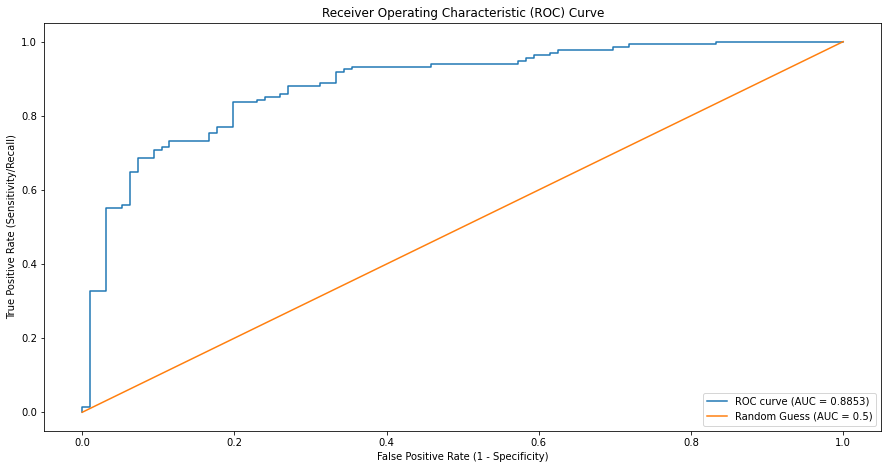

In [17]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [18]:
curve = pd.DataFrame(data = {'fpr': fpr,'tpr':tpr, 'threshold':thresholds})
curve['dist_to_optimal'] = np.sqrt((curve['fpr'] - 0)**2 + (curve['tpr'] - 1)**2)
curve

,fpr,tpr,threshold,dist_to_optimal
0,0.000000,0.000000,inf,1.000000
1,0.000000,0.007463,0.983201,0.992537
2,0.000000,0.014925,0.980756,0.985075
3,0.010417,0.014925,0.976241,0.985130
4,0.010417,0.328358,0.908645,0.671723
5,0.031250,0.328358,0.901716,0.672368
6,0.031250,0.552239,0.777963,0.448850
7,0.052083,0.552239,0.772673,0.450780
8,0.052083,0.559701,0.768315,0.443368
9,0.062500,0.559701,0.763956,0.444712


In [19]:
curve['dist_to_optimal'].idxmin()

24

In [20]:
ideal_threshold = curve.loc[24]
ideal_threshold

fpr                0.197917
tpr                0.835821
threshold          0.493885
dist_to_optimal    0.257149
Name: 24, dtype: float64

### Predict with the best threshold value
Although the threshold here is not very different from 0.5 (standard)

In [21]:
y_prob = pipeline.predict_proba(x_test)[:,1]
y_pred_opt_threshold = (y_prob >= ideal_threshold['threshold'])
test_accuracy = accuracy_score(y_test, y_pred_opt_threshold)
test_accuracy

0.8217391304347826

### Plot the confusion matrix

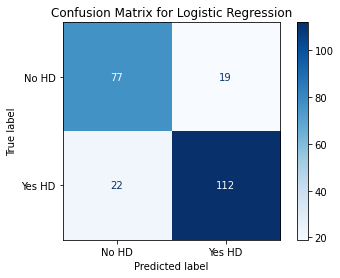

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_opt_threshold, 
    cmap=plt.cm.Blues,
    display_labels=['No HD', 'Yes HD'],
    normalize=None # Set to 'true', 'pred', or 'all' to normalize the counts
)

disp.ax_.set_title('Confusion Matrix for Logistic Regression')
plt.show()

Performance metrics:
1. Sensitivity (Recall): 83.5%
2. Specificity: 80.2%
3. Precision: 85.5%
4. Accuracy: 82.17%

In [23]:
f1 = f1_score(y_test, y_pred_opt_threshold)
f1

0.8452830188679246

### Reflections on Logistic Regression

Cross val gave a test accuracy of 79.6%, which is more robust, however when test-train split was done the accuracy changed to 81.3% which is a minor change (shuffle was True for both cases as this is not randomly ordered dataset). We then drew the ROC AUC curve (AUC is 0.88) and found the ideal threshold (which was very close to 0.5) changing the predictions by switching threshold to ideal further improved the accuracy to 82.17%. We will compare this with other classification models.

## Random Forest

### Fit the model

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [25]:
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)

In [26]:
rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=None,        
    min_samples_leaf=1,    
    random_state=42,       
    n_jobs=-1          
)

In [27]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', rf_model)])

In [28]:
scores = cross_validate(estimator=pipeline, X=x_train, y=y_train, cv=kf, scoring='accuracy', return_train_score = True)

In [29]:
scores['train_score'].mean(), scores['test_score'].mean()

(1.0, 0.8071817448581798)

### Hyper parameter tuning using Gridsearch CV

In [30]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 250],
    'classifier__max_depth': [3,4,5,6,7,8, None],
    'classifier__min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring='accuracy', cv= kf, verbose=2)

In [31]:
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 105 candidates, totalling 420 fits
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=3, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__

[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=150; total time=   0.2s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=250; total time=   0.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__n_

[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_estimators=150; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__n_e

[CV] END classifier__max_depth=6, classifier__min_samples_leaf=5, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=5, classifier__n_estimators=250; total time=   0.5s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=5, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=5, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=5, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=10, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=10, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=10, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=10, classifier__n

[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=150; total time=   0.2s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=10, class

[CV] END classifier__max_depth=8, classifier__min_samples_leaf=10, classifier__n_estimators=250; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_l

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [3, 4, 5, 6, 7, 8, None],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__n_estimators': [50, 100, 150, 200, 250]},
             scoring='accuracy', verbose=2)

In [32]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 50}
Best Cross-Validation Score: 0.8173


In [33]:
best_rf_pipeline = grid_search.best_estimator_

In [34]:
best_rf_pipeline.fit(x_train,y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=5,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [35]:
y_pred_rf = best_rf_pipeline.predict(x_train)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf)


y_pred_rf = best_rf_pipeline.predict(x_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)
accuracy_rf_train, accuracy_rf_test

(0.8565217391304348, 0.8217391304347826)

### Creating ROC AUC curve

In [36]:
y_pred = best_rf_pipeline.predict_proba(x_test)[:, 1]

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8972325870646767


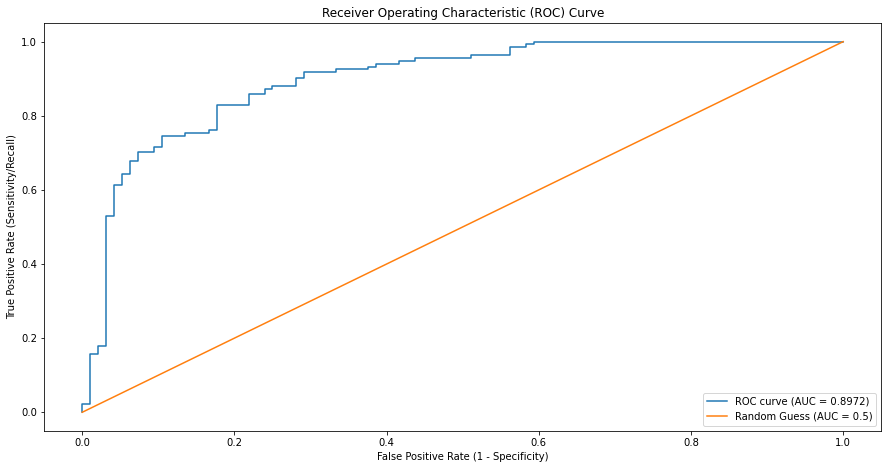

In [38]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [39]:
curve = pd.DataFrame(data = {'fpr': fpr,'tpr':tpr, 'threshold':thresholds})
curve['dist_to_optimal'] = np.sqrt((curve['fpr'] - 0)**2 + (curve['tpr'] - 1)**2)
curve

,fpr,tpr,threshold,dist_to_optimal
0,0.000000,0.000000,inf,1.000000
1,0.000000,0.007463,0.955770,0.992537
2,0.000000,0.022388,0.945968,0.977612
3,0.010417,0.022388,0.943524,0.977667
4,0.010417,0.156716,0.901637,0.843348
5,0.020833,0.156716,0.896616,0.843541
6,0.020833,0.179104,0.892094,0.821160
7,0.031250,0.179104,0.887790,0.821490
8,0.031250,0.529851,0.780573,0.471187
9,0.041667,0.529851,0.777795,0.471992


In [40]:
curve['dist_to_optimal'].idxmin()

26

In [41]:
ideal_threshold = curve.iloc[26]
ideal_threshold

fpr                0.177083
tpr                0.828358
threshold          0.529235
dist_to_optimal    0.246616
Name: 26, dtype: float64

### Predict with the best threshold

In [42]:
y_prob = best_rf_pipeline.predict_proba(x_test)[:,1]
y_pred_opt_threshold = (y_prob >= ideal_threshold['threshold'])
test_accuracy = accuracy_score(y_test, y_pred_opt_threshold)
test_accuracy

0.8260869565217391

### Plot the confusion matrix

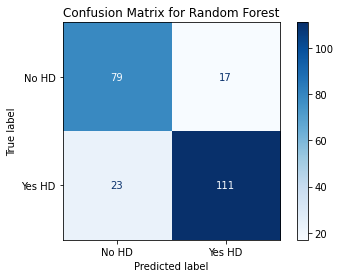

In [43]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_opt_threshold, 
    cmap=plt.cm.Blues,
    display_labels=['No HD', 'Yes HD'],
    normalize=None # Set to 'true', 'pred', or 'all' to normalize the counts
)

disp.ax_.set_title('Confusion Matrix for Random Forest')
plt.show()

Performance metrics:
1. Sensitivity (Recall): 82.8%
2. Specificity: 82.3%
3. Precision: 86.7%
4. Accuracy: 82.6%

In [44]:
f1 = f1_score(y_test, y_pred_opt_threshold)
f1

0.8473282442748091

### Reflections on Random Forest
Since we didn't classify min sample at leaf or max depth, the model memorised the data and train accuracy = 1. Testing accuracy was higher than Logistic Regression.
After hyperparameter tuning and opting for the best classification threshold, RF improved ROC AUC over Logistic Regression and increased specificity and precision. It slightly reduces sensitivity but the slight decrease is acceptable since RF increases ROC AUC the most robust metric. 
Having said that, if the cost for false negatives is very high (very imperative to find all positivs with good recall), it might help to keep the same model and chose a lower threshold that is ~0.49 instead of current 0.52.

## Support Vector Machines

### Fit the model

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [46]:
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)

In [47]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', SVC(random_state=42))])

In [48]:
scores = cross_validate(estimator=pipeline, X=x_train, y=y_train, cv=kf, scoring='accuracy', return_train_score = True)

In [49]:
scores['train_score'].mean(), scores['test_score'].mean()

(0.8946840250031739, 0.776725702379352)

In [50]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier', SVC(random_state=42))])

In [51]:
y_pred_svm = pipeline.predict(x_test)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)

y_pred_svm = pipeline.predict(x_train)
accuracy_svm_train = accuracy_score(y_train, y_pred_svm)

accuracy_svm_train, accuracy_svm_test

(0.8840579710144928, 0.8043478260869565)

### Trying downsampling since SVM are now great with very large datasets
The complexity of SVM computation scales with the size of dataset (since SVM calculates the distance between each point with every other point). Also SVM is not very good at handling class imbalance. In this example, the dataset is balanced and the computation didn't take too much time, we will still try downsampling to learn)

In [52]:
df_hd = df[df['num'] == 1]
df_no_hd = df[df['num'] == 0]
df_hd.shape

(509, 23)

In [53]:
df_hd_downsampled = resample(df_hd, replace=False, n_samples=400, random_state=42)
len(df_hd_downsampled)

400

In [54]:
df_no_hd_downsampled = resample(df_no_hd, replace=False, n_samples=400, random_state=42)
len(df_no_hd_downsampled)

400

In [55]:
df_downsampled = pd.concat([df_no_hd_downsampled, df_hd_downsampled])
df_downsampled.shape

(800, 23)

In [56]:
x = df_downsampled.drop('num', axis = 1)
x.shape

(800, 22)

In [57]:
y = df_downsampled['num']
y.shape

(800,)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [59]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', SVC(random_state=42))])

In [60]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier', SVC(random_state=42))])

In [61]:
y_pred_svm = pipeline.predict(x_train)
accuracy_svm_train = accuracy_score(y_train, y_pred_svm)

y_pred_svm = pipeline.predict(x_test)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)

accuracy_svm_train, accuracy_svm_test

(0.8666666666666667, 0.82)

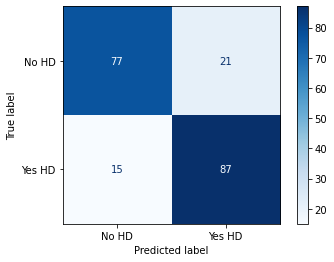

In [62]:
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred_svm, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

### Tune model using gridsearch CV

In [63]:
param_grid = {
    'classifier__C': [0.5, 1, 10, 100],
    'classifier__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__kernel': ['rbf']
}

grid_search = GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring='accuracy', cv= kf, verbose=2)

In [64]:
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END classifier__C=0.5, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.5, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s

[CV] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=rbf; total time=   0.0s


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                                       ('scaler', StandardScaler()),
                                       ('classifier', SVC(random_state=42))]),
             param_grid={'classifier__C': [0.5, 1, 10, 100],
                         'classifier__gamma': ['scale', 1, 0.1, 0.01, 0.001,
                                               0.0001],
                         'classifier__kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [65]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'classifier__C': 0.5, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
Best Cross-Validation Score: 0.8000


### Build evaluate, draw and interpret SVM

In [66]:
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', SVC(C=0.5, gamma=0.001, kernel='rbf', probability= True, random_state=42))])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier',
                 SVC(C=0.5, gamma=0.001, probability=True, random_state=42))])

In [67]:
y_pred_svm = pipeline.predict(x_test)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)

y_pred_svm = pipeline.predict(x_train)
accuracy_svm_train = accuracy_score(y_train, y_pred_svm)

accuracy_svm_train, accuracy_svm_test

(0.81, 0.79)

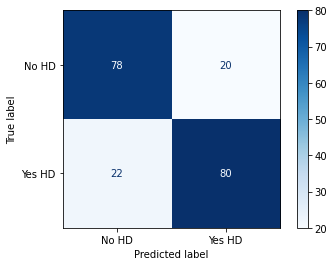

In [68]:
y_pred = pipeline.predict(x_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

Performance metrics:
1. Sensitivity (Recall): 86.57%
2. Specificity: 75%
3. Precision: 82.86%
4. Accuracy: 81.74%

In [73]:
y_pred_svm = pipeline.predict(x_test)
f1 = f1_score(y_test, y_pred_svm)
f1

0.792079207920792

In [74]:
y_pred = pipeline.predict_proba(x_test)[:, 1]

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8847539015606242


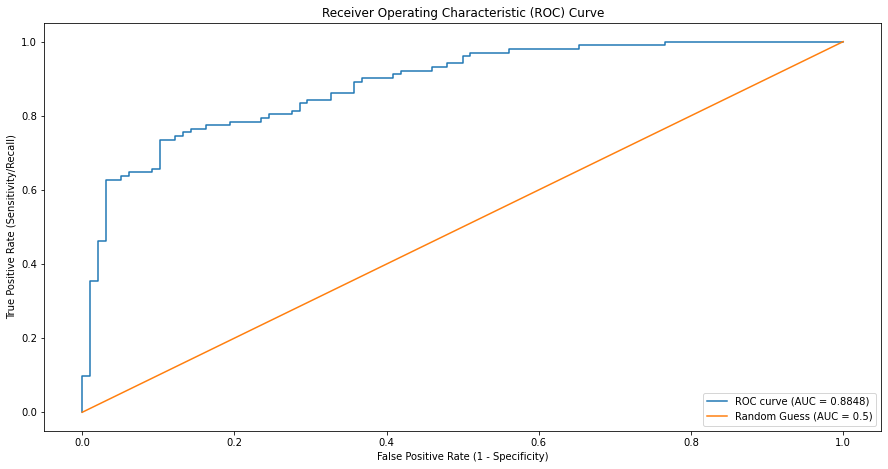

In [76]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

### Using Principal Component Analysis to draw the correlation and boundary

In [77]:
x_train = imputer.fit_transform(x_train)
x_train = scaler.fit_transform(x_train)

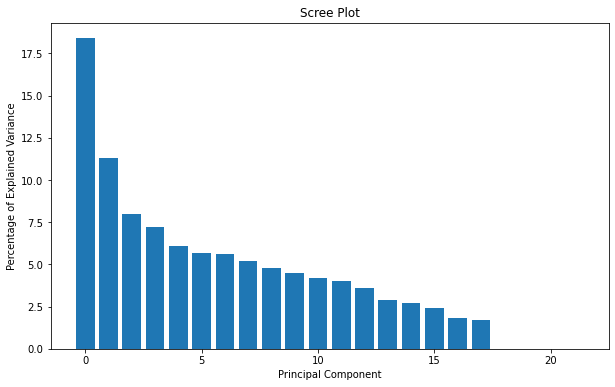

In [78]:
pca = PCA()
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = [str(x) for x in range(len(per_var)+1)]

plt.figure(figsize=(10, 6))
plt.bar(x=np.arange(len(per_var)), height=per_var)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

The goal of the scree plot is to ensure that the first 2 components explain much larger variance than the rest (so that the data can be simplified in 2 dimensions for easy visual here). The reason we only see 17 bars is because 5 featres are perfectly correlated with the first 17 features ( this includes 4 OHE features, dont know the last)

In [79]:
train_pc1_coords = x_train_pca[:,0]
train_pc2_coords = x_train_pca[:,1]
pca_train_scaled = np.column_stack((train_pc1_coords, train_pc2_coords))

In [80]:
param_grid = {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(estimator= SVC(), param_grid=param_grid, scoring='accuracy', cv= kf, verbose=2)
grid_search.fit(pca_train_scaled,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.5, 1, 10, 100],
                         'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [81]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8050


Reducing the data 2 most important dimensions for ease of plotting reduced the accuracy from 81.7% to 80.8%. This is because explained variance was not great for the second var. We can go on to plot the decision boundaries and visualise this but skipping it. How to do this is shown here:
https://www.youtube.com/watch?v=8A7L0GsBiLQ&t=2104s

### Reflections on Support Vector Machines:

This technique is suited for cases where we wnat to accurately predict the output without caring much about how we got there (infinite dimensions in RBF). In this use case, however, SVM has an accuracy of 81.7% after tuning hyper parameters. This is worse than the accuracy from Random Forest (82.6%) and Logistic Regression (82.1%)

## Gradient boosting

### Fit the model

In [10]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', gb_clf)])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [11]:
y_pred_gb = pipeline.predict(x_test)
accuracy_gb_test = accuracy_score(y_test, y_pred_gb)

y_pred_gb = pipeline.predict(x_train)
accuracy_gb_train = accuracy_score(y_train, y_pred_gb)

accuracy_gb_train, accuracy_gb_test

(0.936231884057971, 0.8043478260869565)

### Tune the model

In [12]:
param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 150],
    'classifier__learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
    'classifier__max_depth': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring='accuracy', cv= kf, verbose=2)
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier__max_depth=2, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=1, classifier_

[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=1, classifier__max_depth=5, classifier__n_estimators=150; total time=   0.3s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=10; total ti

[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=100

[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=50; to

[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_es

[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [1, 0.5, 0.1, 0.01,
                                                       0.001],
                         'classifier__max_depth': [2, 3, 4, 5],
                         'classifier__n_estimators': [10, 20, 50, 100, 150]},
             scoring='accuracy', verbose=2)

In [13]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.8043


In [14]:
best_gb_pipeline = grid_search.best_estimator_
best_gb_pipeline

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(max_depth=2, random_state=42))])

In [15]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=42)
best_gb_pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', gb_clf)])
best_gb_pipeline.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(max_depth=2, random_state=42))])

In [16]:
y_pred_gb = best_gb_pipeline.predict(x_test)
accuracy_gb_test = accuracy_score(y_test, y_pred_gb)

y_pred_gb = best_gb_pipeline.predict(x_train)
accuracy_gb_train = accuracy_score(y_train, y_pred_gb)

accuracy_gb_train, accuracy_gb_test

(0.8739130434782608, 0.8043478260869565)

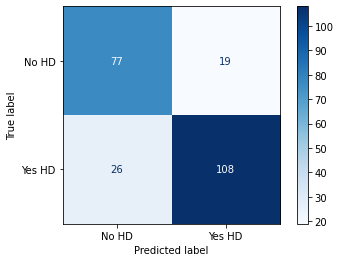

In [17]:
y_pred = best_gb_pipeline.predict(x_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

Performance metrics:
1. Sensitivity (Recall): 80.6%
2. Specificity: 80.2%
3. Precision: 85%
4. Accuracy: 80.43%

In [18]:
y_pred = best_gb_pipeline.predict(x_test)
f1 = f1_score(y_test, y_pred)
f1

0.8275862068965518

In [19]:
y_pred = best_gb_pipeline.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.882734763681592


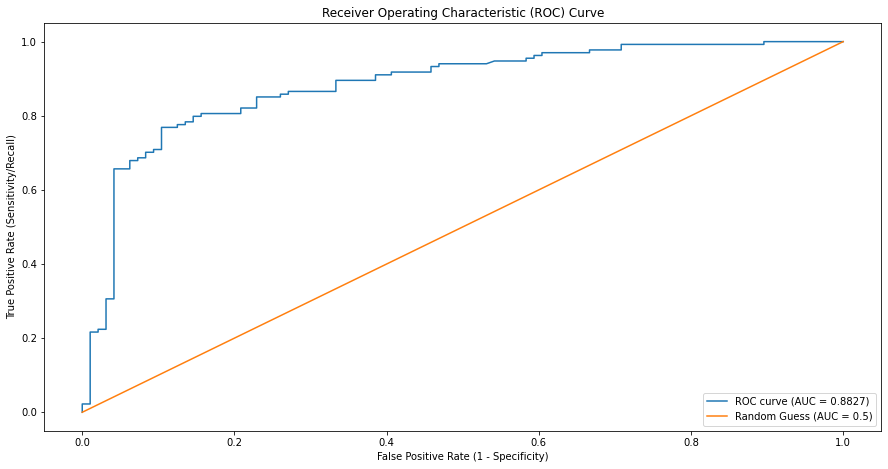

In [20]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

### Reflections on Gradient Boost:
While Gradient Boosting gave a strong result of 80% test accuracy however, RF has an edge of 82%. This is because RF focuses on reducing variance by being a more robust method of prediction, while GB focuses on progressively reducing bias. We can see this effect in GB train accuracy being 87% which is much better than RF train accuracy of 85.6%. RF in this case proves to be a much better and robust estimator with higher ROC AUC also due to the small sample size which has many outliers. 
Models like XGB or Light GBM improve on GB, those can yield better performance.

## XGBoost:

### Fit the model

In [21]:
sum(y)/len(y)
## Roughly balanced dataset, no need to startify (i.e. ensure both train and test contain equal percentage of yes)

0.5532608695652174

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, shuffle=True)

In [23]:
sum(y_train)/len(y_train), sum(y_test)/len(y_test)

(0.5434782608695652, 0.5826086956521739)

In [29]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed = 42, early_stopping_rounds=10, eval_metric='error')
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', clf_xgb)])
# pipeline.fit(x_train, y_train,  classifier__eval_set=[(x_test, y_test)])

clf_xgb.fit(x_train, y_train, verbose=True,  eval_set=[(x_test, y_test)])

[0]	validation_0-error:0.23043
[1]	validation_0-error:0.23478
[2]	validation_0-error:0.21739
[3]	validation_0-error:0.20870
[4]	validation_0-error:0.22609
[5]	validation_0-error:0.22174
[6]	validation_0-error:0.20870
[7]	validation_0-error:0.21304
[8]	validation_0-error:0.20435
[9]	validation_0-error:0.20000
[10]	validation_0-error:0.19130
[11]	validation_0-error:0.18696
[12]	validation_0-error:0.18696
[13]	validation_0-error:0.18696
[14]	validation_0-error:0.18261
[15]	validation_0-error:0.18261
[16]	validation_0-error:0.18261
[17]	validation_0-error:0.19130
[18]	validation_0-error:0.19130
[19]	validation_0-error:0.18261
[20]	validation_0-error:0.18261
[21]	validation_0-error:0.18261
[22]	validation_0-error:0.17826
[23]	validation_0-error:0.18696
[24]	validation_0-error:0.18261
[25]	validation_0-error:0.18261
[26]	validation_0-error:0.17826
[27]	validation_0-error:0.17826
[28]	validation_0-error:0.17826
[29]	validation_0-error:0.17391
[30]	validation_0-error:0.17826
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

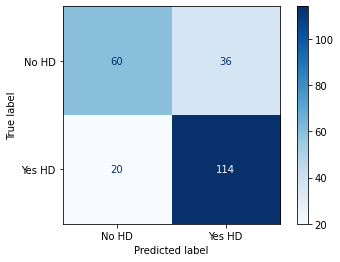

In [28]:
y_pred = pipeline.predict(x_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

Accuracy: 81.7%

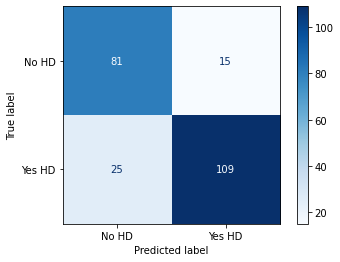

In [30]:
y_pred = clf_xgb.predict(x_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

Performance metrics:
1. Sensitivity (Recall): 81.3%
2. Specificity: 84.4%
3. Precision: 87.9%
4. Accuracy: 82.6%

In [32]:
y_pred = pipeline.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8107120646766169


In [33]:
y_pred = clf_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8856498756218906


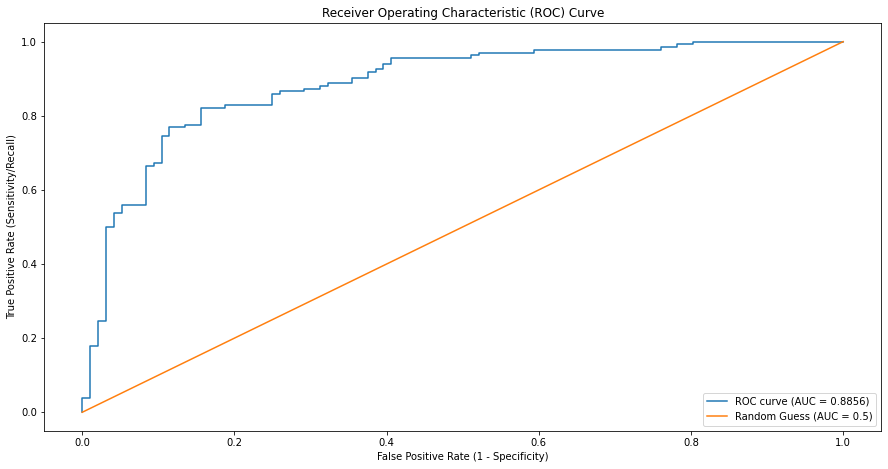

In [34]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

### Optimize hyperparameters

In [35]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed = 42, eval_metric='error')
pipeline = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('classifier', clf_xgb)])
param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
    'classifier__gamma': [0, 0.25, 1],
    'classifier__reg_lambda': [0, 1, 10]
}

grid_search = GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring='accuracy', cv= kf, verbose=2)
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, clas

[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_dept

[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier

[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=3, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=1, classifier_

[CV] END classifier__gamma=0.25, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0

[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=0.25, classifier__learning

[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=1, classifier__max_depth=4, classifier__r

[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_dept

[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__reg_lambda=0; total time=   0.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorica...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__gamma': [0, 0.25, 1],
                         'classifier__learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__reg_lambda': [0, 1, 10]},
             scoring='accuracy', verbose=2)

In [36]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'classifier__gamma': 0.25, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__reg_lambda': 0}
Best Cross-Validation Score: 0.8173


In [37]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'classifier__gamma': 0.25, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__reg_lambda': 0}
Best Cross-Validation Score: 0.8173


In [38]:
best_xgb = grid_search.best_estimator_
best_xgb.fit(x_train, y_train)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               feature_types=None, gamma=0.25, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

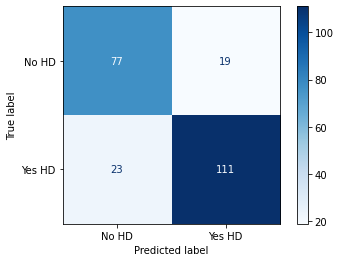

In [39]:
y_pred = best_xgb.predict(x_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, y_pred, cmap=plt.cm.Blues, display_labels=['No HD', 'Yes HD'], normalize=None)
plt.show()

Performance metrics:
1. Sensitivity (Recall): 82.8%
2. Specificity: 80.2%
3. Precision: 85.4%
4. Accuracy: 81.7%

In [40]:
y_pred = best_xgb.predict(x_test)
f1 = f1_score(y_test, y_pred)
f1

0.8409090909090908

In [41]:
y_pred = best_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC is ',roc_auc)

ROC AUC is  0.8766324626865671


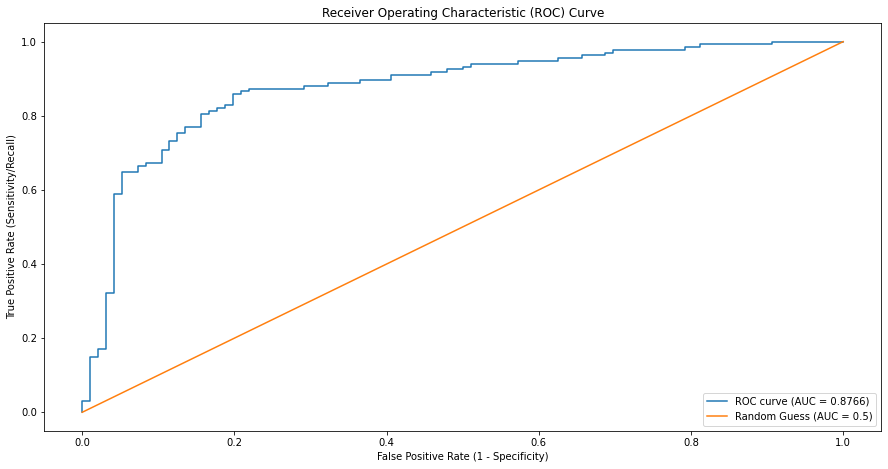

In [42]:
plt.figure(figsize=(15,7.5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [43]:
curve = pd.DataFrame(data = {'fpr': fpr,'tpr':tpr, 'threshold':thresholds})
curve['dist_to_optimal'] = np.sqrt((curve['fpr'] - 0)**2 + (curve['tpr'] - 1)**2)
curve

,fpr,tpr,threshold,dist_to_optimal
0,0.000000,0.000000,inf,1.000000
1,0.000000,0.007463,0.996089,0.992537
2,0.000000,0.029851,0.993968,0.970149
3,0.010417,0.029851,0.993748,0.970205
4,0.010417,0.149254,0.972539,0.850810
...,...,...,...,...
67,0.812500,0.985075,0.042737,0.812637
68,0.812500,0.992537,0.040964,0.812534
69,0.906250,0.992537,0.024885,0.906281
70,0.906250,1.000000,0.024475,0.906250


In [44]:
a = curve['dist_to_optimal'].idxmin()
ideal_threshold = curve.iloc[a]

In [45]:
y_prob = best_xgb.predict_proba(x_test)[:,1]
y_pred_opt_threshold = (y_prob >= ideal_threshold['threshold'])
test_accuracy = accuracy_score(y_test, y_pred_opt_threshold)
test_accuracy

0.8347826086956521

In [46]:
f1 = f1_score(y_test, y_pred_opt_threshold)
f1

0.8582089552238806

### Draw the XGB Tree

In [8]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed = 42, eval_metric='error', gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, n_estimators=1)
clf_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10")

### Reflections on XGBoost
XGBoost performed better without the pipeline (without knn imputing and standard scaling) becuase its better at handling missing data than other models (and potentially knn), however, the ROC of XGBoost (0.8856) was still not as great as Random Forest (0.8972). XGBoost does well for relatively large datasets and has great explainability, however since our data is only 900 samples and has the issue of outlier samples with a need for a robust model with very little overfitting, Random FOrest is best utilised ofr this use case.
I also tried plotting the XGB tree but facing some issues with graphviz installation.